### PCA: Electrode Grouping 4  
  
**Grouping 4: Front/Back**  
  
The x-axis electrodes will show up in both groups.  
  
**Front:** Fp1, Fp2, F3, F7, Fz, F4, F8, T3, C3, Cz, C4, T4  
**Back:** O1, O2, T5, P3, Pz, P4, T6, T3, C3, Cz, C4, T4

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import fastparquet, pyarrow
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

In [3]:
df = pd.read_csv('nulls_dropped.csv')

In [4]:
df = df.drop(columns = 'row')

##### Target Variable Distribution for Dataframe without EEGs and Spectrograms Missing Values

In [5]:
df['expert_consensus'].value_counts(normalize = True)

expert_consensus
Seizure    0.209216
Other      0.189732
GPD        0.157017
GRDA       0.155822
LRDA       0.146853
LPD        0.141360
Name: proportion, dtype: float64

##### Adding Column to Keep Track of Original Index

In [6]:
df['row'] = [i for i in range(df.shape[0])]

##### Splitting Dataframe by Activity Type

In [7]:
def activity_df(activity):
    return pd.DataFrame(df[df['expert_consensus'] == activity]).reset_index().drop(columns = 'index')

In [8]:
seizure_df = activity_df('Seizure')
lpd_df = activity_df('LPD')
gpd_df = activity_df('GPD')
lrda_df = activity_df('LRDA')
grda_df = activity_df('GRDA')
other_df = activity_df('Other')

##### Function to Read and Scale Sub EEGs

In [9]:
def scale(df, row):
    eeg = pd.read_parquet('train_eegs/{}.parquet'.format(df['eeg_id'][row]), engine = 'pyarrow')
    first_row = int(df['eeg_label_offset_seconds'][row] * 200)
    last_row = int(first_row + 10000)
    sub_eeg = eeg[first_row: last_row]
    electrodes = sub_eeg.columns
    scaler = StandardScaler()
    sub_eeg = scaler.fit_transform(sub_eeg)
    sub_eeg = pd.DataFrame(sub_eeg, columns = electrodes)
    return sub_eeg

##### Function for Plotting EEG Signals

In [10]:
def activity_signal_plots(sub_eegs, activities, electrodes, h, w):
    fig, axs = plt.subplots(len(electrodes), len(sub_eegs))
    fig.set_figheight(h)
    fig.set_figwidth(w)
    fig.tight_layout()
    for i in range(len(electrodes)):
        if len(sub_eegs) == 1:
            axs[i].plot(sub_eegs[0][electrodes[i]])
            axs[i].set_title('{}_{}'.format(activities[0], electrodes[i]))
        else:
            for j in range(len(sub_eegs)):
                axs[i][j].plot(sub_eegs[j][electrodes[i]])
                if len(activities) > 1:
                    axs[i][j].set_title('{}_{}'.format(activities[j], electrodes[i]))
                else:
                    axs[i][j].set_title('{}_{}'.format(activities[0], electrodes[i]))
    plt.show()

##### PCA Function

In [11]:
def pca_function(sub_eeg, group, n):
    sub_eeg = sub_eeg[group]
    pca = PCA(n_components = n, random_state = 42)
    sub_eeg = pca.fit_transform(sub_eeg)
    ratio = pca.explained_variance_ratio_
    sub_eeg = pd.DataFrame(sub_eeg, columns = ['component_{}'.format(i) for i in range(n)])
    return sub_eeg, ratio

### EEG Indexes by Activity Type  
  
These will be manually set to match the random indexes generated in the first notebook so that PCA is being done with the same sets of sub EEGs.

In [12]:
seizure_random = [16905, 3162, 9351, 17307, 10034]
lpd_random = [7342, 8731, 4898, 11493, 639]
gpd_random = [4595, 11408, 537, 12154, 1935]
lrda_random = [388, 11148, 1711, 5242, 3911]
grda_random = [12264, 5631, 8640, 3704, 11767]
other_random = [9492, 10642, 13840, 3519, 1577]

### Grouping 4: Front/Back  
  
**Front:** Fp1, Fp2, F3, F7, Fz, F4, F8, T3, C3, Cz, C4, T4  
**Back:** O1, O2, T5, P3, Pz, P4, T6, T3, C3, Cz, C4, T4

In [13]:
front = ['Fp1', 'F3', 'C3', 'F7', 'T3', 'Fz', 'Cz', 'Fp2', 'F4', 'C4', 'F8', 'T4']
back = ['C3', 'P3', 'T3', 'T5', 'O1', 'Cz', 'Pz', 'C4', 'P4', 'T4', 'T6', 'O2']

In [14]:
df['expert_consensus'].value_counts(normalize = True)

expert_consensus
Seizure    0.209216
Other      0.189732
GPD        0.157017
GRDA       0.155822
LRDA       0.146853
LPD        0.141360
Name: proportion, dtype: float64

In [15]:
s_count_norm = df['expert_consensus'].value_counts(normalize = True)[0]
o_count_norm = df['expert_consensus'].value_counts(normalize = True)[1]
gpd_count_norm = df['expert_consensus'].value_counts(normalize = True)[2]
grda_count_norm = df['expert_consensus'].value_counts(normalize = True)[3]
lrda_count_norm = df['expert_consensus'].value_counts(normalize = True)[4]
lpd_count_norm = df['expert_consensus'].value_counts(normalize = True)[5]

In [16]:
norm_list = [s_count_norm, o_count_norm, gpd_count_norm, grda_count_norm,
             lrda_count_norm, lpd_count_norm]
activity_counts_1000 = []
for norm in norm_list:
    activity_count = norm * 1000
    activity_counts_1000.append(activity_count)

In [17]:
activity_counts_1000

[209.21557739201816,
 189.73176561481444,
 157.01731089596564,
 155.82220719959437,
 146.85289359955576,
 141.3602452980516]

In [18]:
209 + 190 + 157 + 156 + 147 + 141

1000

In [19]:
seizure_indexes = [i for i in range(seizure_df.shape[0])]
other_indexes = [i for i in range(other_df.shape[0])]
gpd_indexes = [i for i in range(gpd_df.shape[0])]
grda_indexes = [i for i in range(grda_df.shape[0])]
lrda_indexes = [i for i in range(lrda_df.shape[0])]
lpd_indexes = [i for i in range(lpd_df.shape[0])]

In [20]:
seizure_norm1000 = np.random.choice(seizure_indexes, size = 209, replace = False)
other_norm1000 = np.random.choice(other_indexes, size = 190, replace = False)
gpd_norm1000 = np.random.choice(gpd_indexes, size = 157, replace = False)
grda_norm1000 = np.random.choice(grda_indexes, size = 156, replace = False)
lrda_norm1000 = np.random.choice(lrda_indexes, size = 147, replace = False)
lpd_norm1000 = np.random.choice(lpd_indexes, size = 141, replace = False)

In [21]:
evr2 = []
evr3 = []
evr4 = []

In [22]:
for i in seizure_norm1000:
    seizure_f2components, seizure_evrf2 = pca_function(scale(seizure_df, i), front, 2)
    seizure_b2components, seizure_evrb2 = pca_function(scale(seizure_df, i), back, 2)
    evr2.append(seizure_evrf2.sum())
    evr2.append(seizure_evrb2.sum())
    
    seizure_f3components, seizure_evrf3 = pca_function(scale(seizure_df, i), front, 3)
    seizure_b3components, seizure_evrb3 = pca_function(scale(seizure_df, i), back, 3)
    evr3.append(seizure_evrf3.sum())
    evr3.append(seizure_evrb3.sum())
    
    seizure_f4components, seizure_evrf4 = pca_function(scale(seizure_df, i), front, 4)
    seizure_b4components, seizure_evrb4 = pca_function(scale(seizure_df, i), back, 4)
    evr4.append(seizure_evrf4.sum())
    evr4.append(seizure_evrb4.sum())

In [23]:
for i in other_norm1000:
    other_f2components, other_evrf2 = pca_function(scale(other_df, i), front, 2)
    other_b2components, other_evrb2 = pca_function(scale(other_df, i), back, 2)
    evr2.append(other_evrf2.sum())
    evr2.append(other_evrb2.sum())
    
    other_f3components, other_evrf3 = pca_function(scale(other_df, i), front, 3)
    other_b3components, other_evrb3 = pca_function(scale(other_df, i), back, 3)
    evr3.append(other_evrf3.sum())
    evr3.append(other_evrb3.sum())
    
    other_f4components, other_evrf4 = pca_function(scale(other_df, i), front, 4)
    other_b4components, other_evrb4 = pca_function(scale(other_df, i), back, 4)
    evr4.append(other_evrf4.sum())
    evr4.append(other_evrb4.sum())

In [24]:
for i in gpd_norm1000:
    gpd_f2components, gpd_evrf2 = pca_function(scale(gpd_df, i), front, 2)
    gpd_b2components, gpd_evrb2 = pca_function(scale(gpd_df, i), back, 2)
    evr2.append(gpd_evrf2.sum())
    evr2.append(gpd_evrb2.sum())
    
    gpd_f3components, gpd_evrf3 = pca_function(scale(gpd_df, i), front, 3)
    gpd_b3components, gpd_evrb3 = pca_function(scale(gpd_df, i), back, 3)
    evr3.append(gpd_evrf3.sum())
    evr3.append(gpd_evrb3.sum())
    
    gpd_f4components, gpd_evrf4 = pca_function(scale(gpd_df, i), front, 4)
    gpd_b4components, gpd_evrb4 = pca_function(scale(gpd_df, i), back, 4)
    evr4.append(gpd_evrf4.sum())
    evr4.append(gpd_evrb4.sum())

In [25]:
for i in grda_norm1000:
    grda_f2components, grda_evrf2 = pca_function(scale(grda_df, i), front, 2)
    grda_b2components, grda_evrb2 = pca_function(scale(grda_df, i), back, 2)
    evr2.append(grda_evrf2.sum())
    evr2.append(grda_evrb2.sum())
    
    grda_f3components, grda_evrf3 = pca_function(scale(grda_df, i), front, 3)
    grda_b3components, grda_evrb3 = pca_function(scale(grda_df, i), back, 3)
    evr3.append(grda_evrf3.sum())
    evr3.append(grda_evrb3.sum())
    
    grda_f4components, grda_evrf4 = pca_function(scale(grda_df, i), front, 4)
    grda_b4components, grda_evrb4 = pca_function(scale(grda_df, i), back, 4)
    evr4.append(grda_evrf4.sum())
    evr4.append(grda_evrb4.sum())

In [26]:
for i in lrda_norm1000:
    lrda_f2components, lrda_evrf2 = pca_function(scale(lrda_df, i), front, 2)
    lrda_b2components, lrda_evrb2 = pca_function(scale(lrda_df, i), back, 2)
    evr2.append(lrda_evrf2.sum())
    evr2.append(lrda_evrb2.sum())
    
    lrda_f3components, lrda_evrf3 = pca_function(scale(lrda_df, i), front, 3)
    lrda_b3components, lrda_evrb3 = pca_function(scale(lrda_df, i), back, 3)
    evr3.append(lrda_evrf3.sum())
    evr3.append(lrda_evrb3.sum())
    
    lrda_f4components, lrda_evrf4 = pca_function(scale(lrda_df, i), front, 4)
    lrda_b4components, lrda_evrb4 = pca_function(scale(lrda_df, i), back, 4)
    evr4.append(lrda_evrf4.sum())
    evr4.append(lrda_evrb4.sum())

In [27]:
for i in lpd_norm1000:
    lpd_f2components, lpd_evrf2 = pca_function(scale(lpd_df, i), front, 2)
    lpd_b2components, lpd_evrb2 = pca_function(scale(lpd_df, i), back, 2)
    evr2.append(lpd_evrf2.sum())
    evr2.append(lpd_evrb2.sum())
    
    lpd_f3components, lpd_evrf3 = pca_function(scale(lpd_df, i), front, 3)
    lpd_b3components, lpd_evrb3 = pca_function(scale(lpd_df, i), back, 3)
    evr3.append(lpd_evrf3.sum())
    evr3.append(lpd_evrb3.sum())
    
    lpd_f4components, lpd_evrf4 = pca_function(scale(lpd_df, i), front, 4)
    lpd_b4components, lpd_evrb4 = pca_function(scale(lpd_df, i), back, 4)
    evr4.append(lpd_evrf4.sum())
    evr4.append(lpd_evrb4.sum())

In [28]:
evr2_front, evr2_back = [], []
evr3_front, evr3_back = [], []
evr4_front, evr4_back = [], []

In [29]:
for i in range(2000):
    if (i + 1) % 2 == 0:
        evr2_back.append(evr2[i])
        evr3_back.append(evr3[i])
        evr4_back.append(evr4[i])
    else:
        evr2_front.append(evr2[i])
        evr3_front.append(evr3[i])
        evr4_front.append(evr4[i])

In [30]:
print('Variance Explained N = 2 Mean: {}, Median: {}'.format(np.mean(np.asarray(evr2)),
                                                             np.median(np.asarray(evr2))))
print('Variance Explained N = 3 Mean: {}, Median: {}'.format(np.mean(np.asarray(evr3)),
                                                             np.median(np.asarray(evr3))))
print('Variance Explained N = 4 Mean: {}, Median: {}'.format(np.mean(np.asarray(evr4)),
                                                             np.median(np.asarray(evr4))))

Variance Explained N = 2 Mean: 0.8183332681655884, Median: 0.8238712549209595
Variance Explained N = 3 Mean: 0.8974341750144958, Median: 0.9046671986579895
Variance Explained N = 4 Mean: 0.9387907981872559, Median: 0.9464250802993774


In [31]:
print('Front Variance Explained N = 2 Mean: {}, Median: {}'.format(np.mean(np.asarray(evr2_front)),
                                                                  np.median(np.asarray(evr2_front))))
print('Back Variance Explained N = 2 Mean: {}, Median: {}'.format(np.mean(np.asarray(evr2_back)),
                                                                  np.median(np.asarray(evr2_back))))

Front Variance Explained N = 2 Mean: 0.8088622093200684, Median: 0.8170156478881836
Back Variance Explained N = 2 Mean: 0.8278043866157532, Median: 0.8283931016921997


In [32]:
print('Front Variance Explained N = 3 Mean: {}, Median: {}'.format(np.mean(np.asarray(evr3_front)),
                                                                  np.median(np.asarray(evr3_front))))
print('Back Variance Explained N = 3 Mean: {}, Median: {}'.format(np.mean(np.asarray(evr3_back)),
                                                                  np.median(np.asarray(evr3_back))))

Front Variance Explained N = 3 Mean: 0.8936548233032227, Median: 0.9008369445800781
Back Variance Explained N = 3 Mean: 0.9012136459350586, Median: 0.9090996980667114


In [33]:
print('Front Variance Explained N = 4 Mean: {}, Median: {}'.format(np.mean(np.asarray(evr4_front)),
                                                                  np.median(np.asarray(evr4_front))))
print('Back Variance Explained N = 4 Mean: {}, Median: {}'.format(np.mean(np.asarray(evr4_back)),
                                                                  np.median(np.asarray(evr4_back))))

Front Variance Explained N = 4 Mean: 0.9360396862030029, Median: 0.9435523748397827
Back Variance Explained N = 4 Mean: 0.941541850566864, Median: 0.9493715167045593


Based on the above results over 1000 sub EEGs selectively random sampled based on distribution of the target variable split by front and back scalp electrodes, 3 component PCA will be done.

##### Seizure Front/Back

In [34]:
seizure_randoms = np.random.choice(seizure_indexes, size = 3, replace = False)

In [35]:
seizure_front1, seizure_f1r = pca_function(scale(seizure_df, seizure_randoms[0]), front, 3)
seizure_back1, seizure_b1r = pca_function(scale(seizure_df, seizure_randoms[0]), back, 3)
seizure_front2, seizure_f2r = pca_function(scale(seizure_df, seizure_randoms[1]), front, 3)
seizure_back2, seizure_b2r = pca_function(scale(seizure_df, seizure_randoms[1]), back, 3)
seizure_front3, seizure_f3r = pca_function(scale(seizure_df, seizure_randoms[2]), front, 3)
seizure_back3, seizure_b3r = pca_function(scale(seizure_df, seizure_randoms[2]), back, 3)

names = ['front1', 'back1', 'front2', 'back2', 'front3', 'back3']
components = seizure_front1.columns

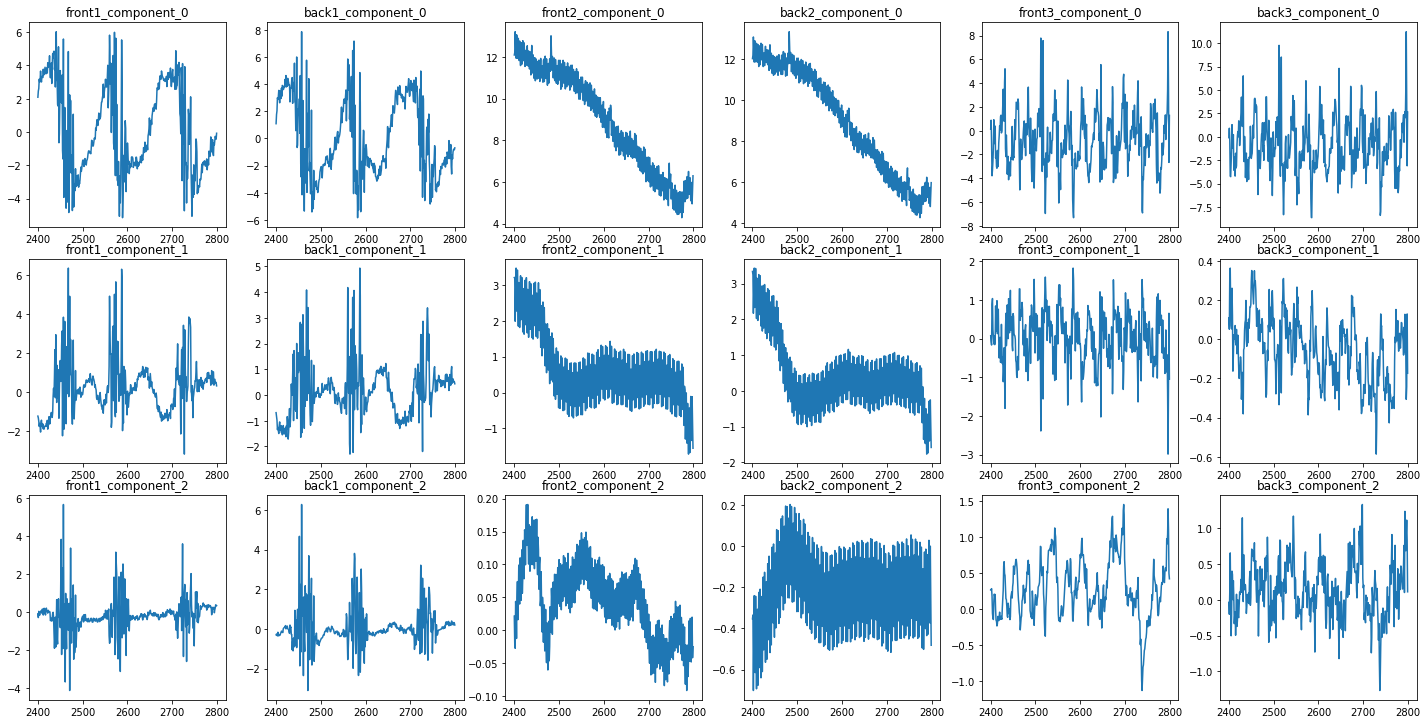

In [36]:
sub_eeg_list = [seizure_front1[2400:2800], seizure_back1[2400:2800],
                seizure_front2[2400:2800], seizure_back2[2400:2800],
                seizure_front3[2400:2800], seizure_back3[2400:2800]]
activity_signal_plots(sub_eeg_list, names, components, 10, 20)

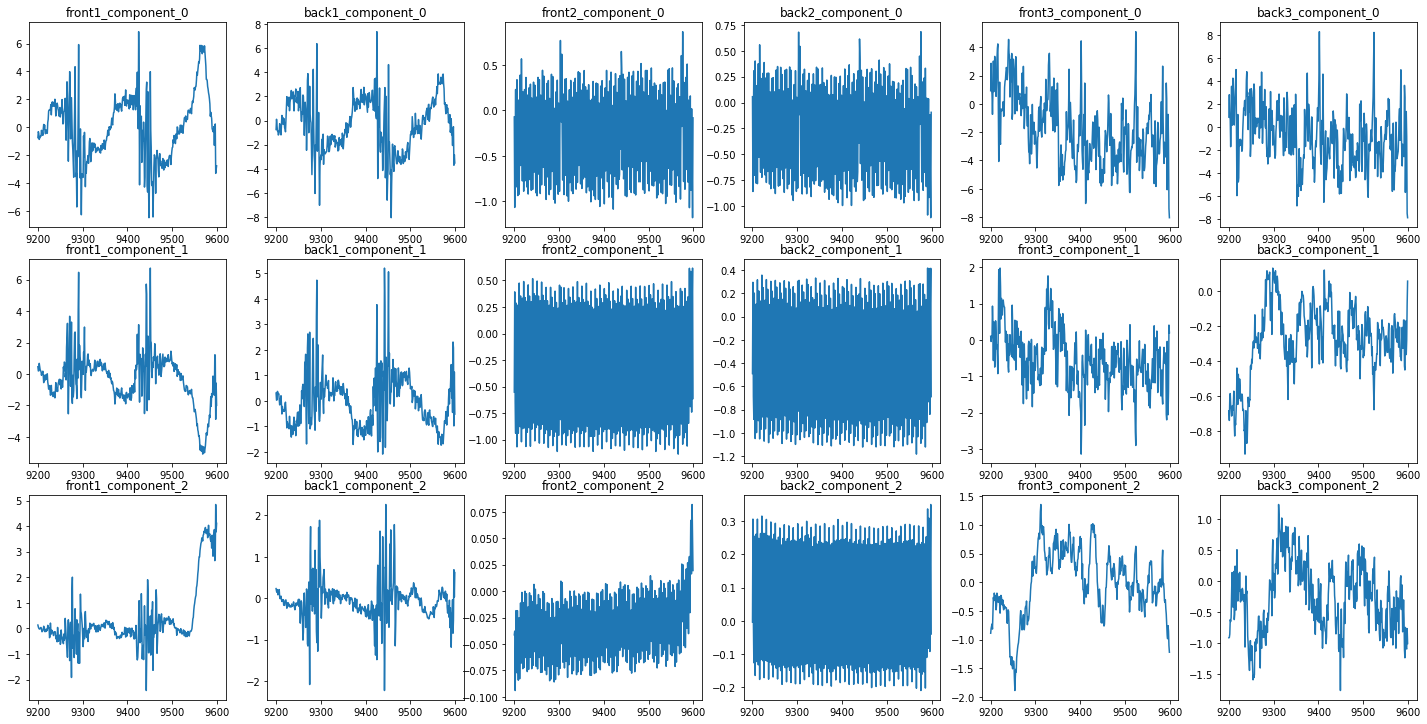

In [37]:
sub_eeg_list = [seizure_front1[9200:9600], seizure_back1[9200:9600],
                seizure_front2[9200:9600], seizure_back2[9200:9600],
                seizure_front3[9200:9600], seizure_back3[9200:9600]]
activity_signal_plots(sub_eeg_list, names, components, 10, 20)

##### LPD Front/Back

In [38]:
lpd_randoms = np.random.choice(lpd_indexes, size = 3, replace = False)

In [39]:
lpd_front1, lpd_f1r = pca_function(scale(lpd_df, lpd_randoms[0]), front, 3)
lpd_back1, lpd_b1r = pca_function(scale(lpd_df, lpd_randoms[0]), back, 3)
lpd_front2, lpd_f2r = pca_function(scale(lpd_df, lpd_randoms[1]), front, 3)
lpd_back2, lpd_b2r = pca_function(scale(lpd_df, lpd_randoms[1]), back, 3)
lpd_front3, lpd_f3r = pca_function(scale(lpd_df, lpd_randoms[2]), front, 3)
lpd_back3, lpd_b3r = pca_function(scale(lpd_df, lpd_randoms[2]), back, 3)

names = ['front1', 'back1', 'front2', 'back2', 'front3', 'back3']
components = lpd_front1.columns

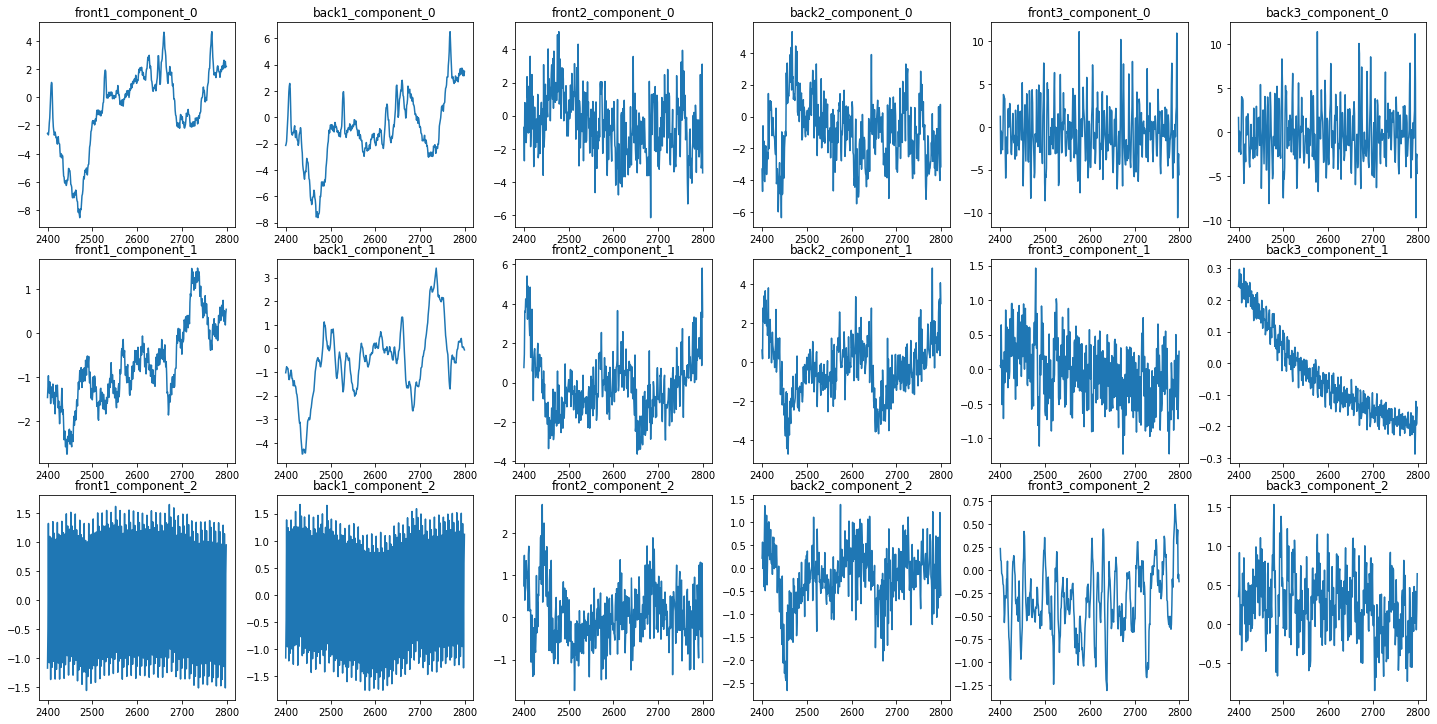

In [40]:
sub_eeg_list = [lpd_front1[2400:2800], lpd_back1[2400:2800],
                lpd_front2[2400:2800], lpd_back2[2400:2800],
                lpd_front3[2400:2800], lpd_back3[2400:2800]]
activity_signal_plots(sub_eeg_list, names, components, 10, 20)

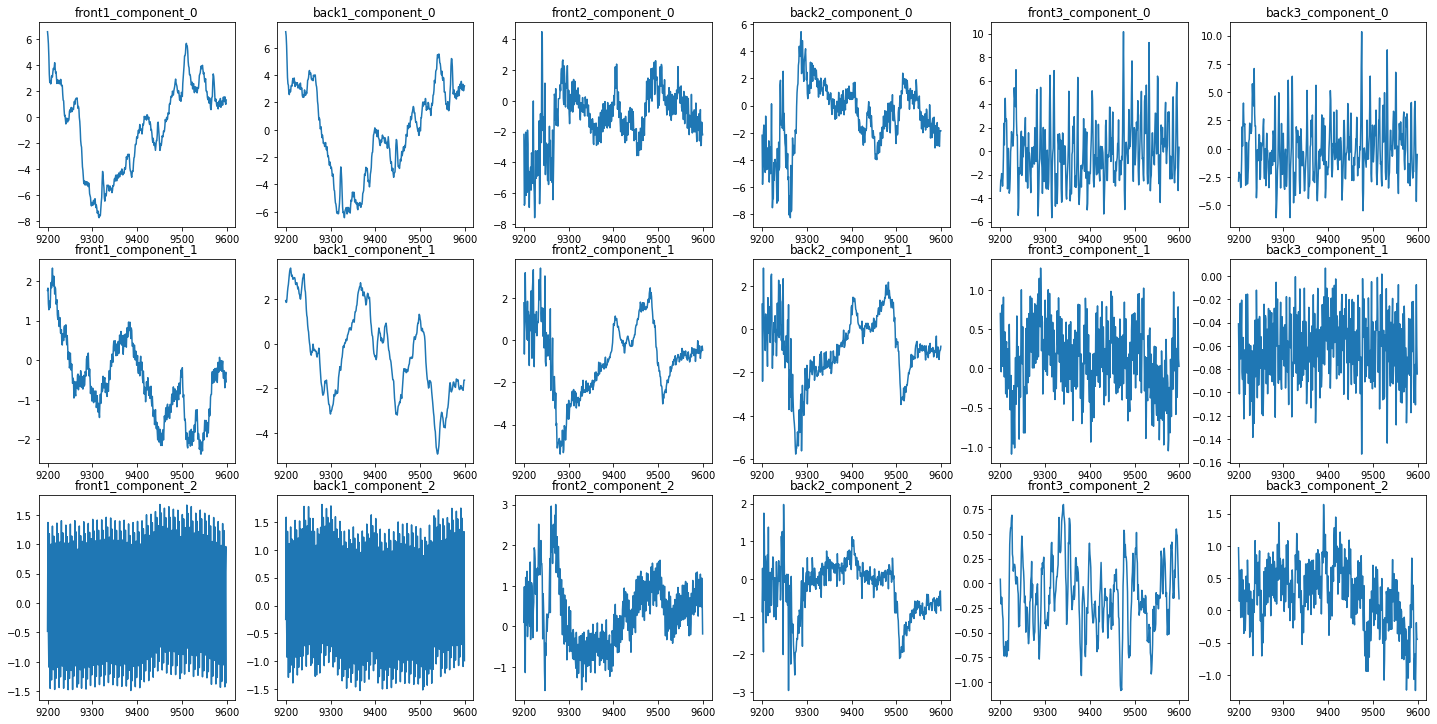

In [41]:
sub_eeg_list = [lpd_front1[9200:9600], lpd_back1[9200:9600],
                lpd_front2[9200:9600], lpd_back2[9200:9600],
                lpd_front3[9200:9600], lpd_back3[9200:9600]]
activity_signal_plots(sub_eeg_list, names, components, 10, 20)

##### GPD Front/Back

In [42]:
gpd_randoms = np.random.choice(gpd_indexes, size = 3, replace = False)

In [43]:
gpd_front1, gpd_f1r = pca_function(scale(gpd_df, gpd_randoms[0]), front, 3)
gpd_back1, gpd_b1r = pca_function(scale(gpd_df, gpd_randoms[0]), back, 3)
gpd_front2, gpd_f2r = pca_function(scale(gpd_df, gpd_randoms[1]), front, 3)
gpd_back2, gpd_b2r = pca_function(scale(gpd_df, gpd_randoms[1]), back, 3)
gpd_front3, gpd_f3r = pca_function(scale(gpd_df, gpd_randoms[2]), front, 3)
gpd_back3, gpd_b3r = pca_function(scale(gpd_df, gpd_randoms[2]), back, 3)

names = ['front1', 'back1', 'front2', 'back2', 'front3', 'back3']
components = gpd_front1.columns

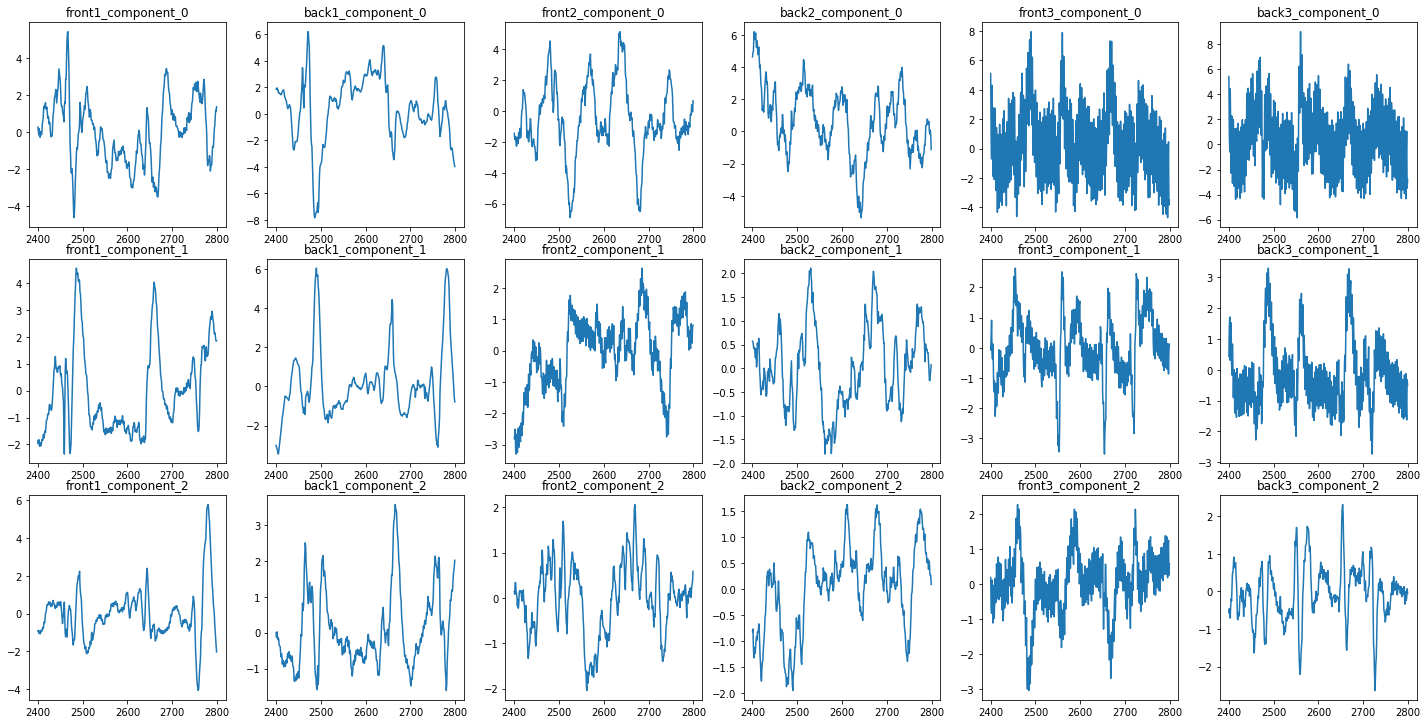

In [44]:
sub_eeg_list = [gpd_front1[2400:2800], gpd_back1[2400:2800],
                gpd_front2[2400:2800], gpd_back2[2400:2800],
                gpd_front3[2400:2800], gpd_back3[2400:2800]]
activity_signal_plots(sub_eeg_list, names, components, 10, 20)

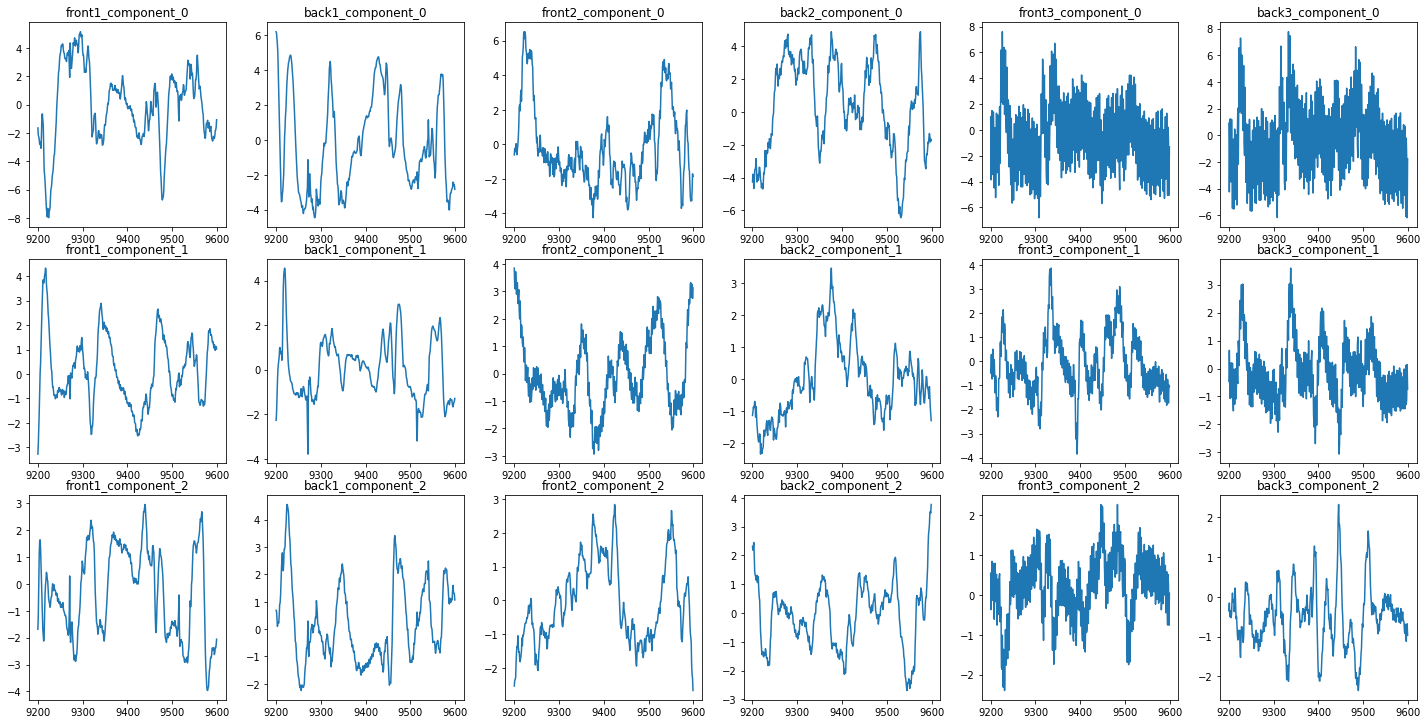

In [45]:
sub_eeg_list = [gpd_front1[9200:9600], gpd_back1[9200:9600],
                gpd_front2[9200:9600], gpd_back2[9200:9600],
                gpd_front3[9200:9600], gpd_back3[9200:9600]]
activity_signal_plots(sub_eeg_list, names, components, 10, 20)

##### LRDA Front/Back

In [46]:
lrda_randoms = np.random.choice(lrda_indexes, size = 3, replace = False)

In [47]:
lrda_front1, lrda_f1r = pca_function(scale(lrda_df, lrda_randoms[0]), front, 3)
lrda_back1, lrda_b1r = pca_function(scale(lrda_df, lrda_randoms[0]), back, 3)
lrda_front2, lrda_f2r = pca_function(scale(lrda_df, lrda_randoms[1]), front, 3)
lrda_back2, lrda_b2r = pca_function(scale(lrda_df, lrda_randoms[1]), back, 3)
lrda_front3, lrda_f3r = pca_function(scale(lrda_df, lrda_randoms[2]), front, 3)
lrda_back3, lrda_b3r = pca_function(scale(lrda_df, lrda_randoms[2]), back, 3)

names = ['front1', 'back1', 'front2', 'back2', 'front3', 'back3']
components = lrda_front1.columns

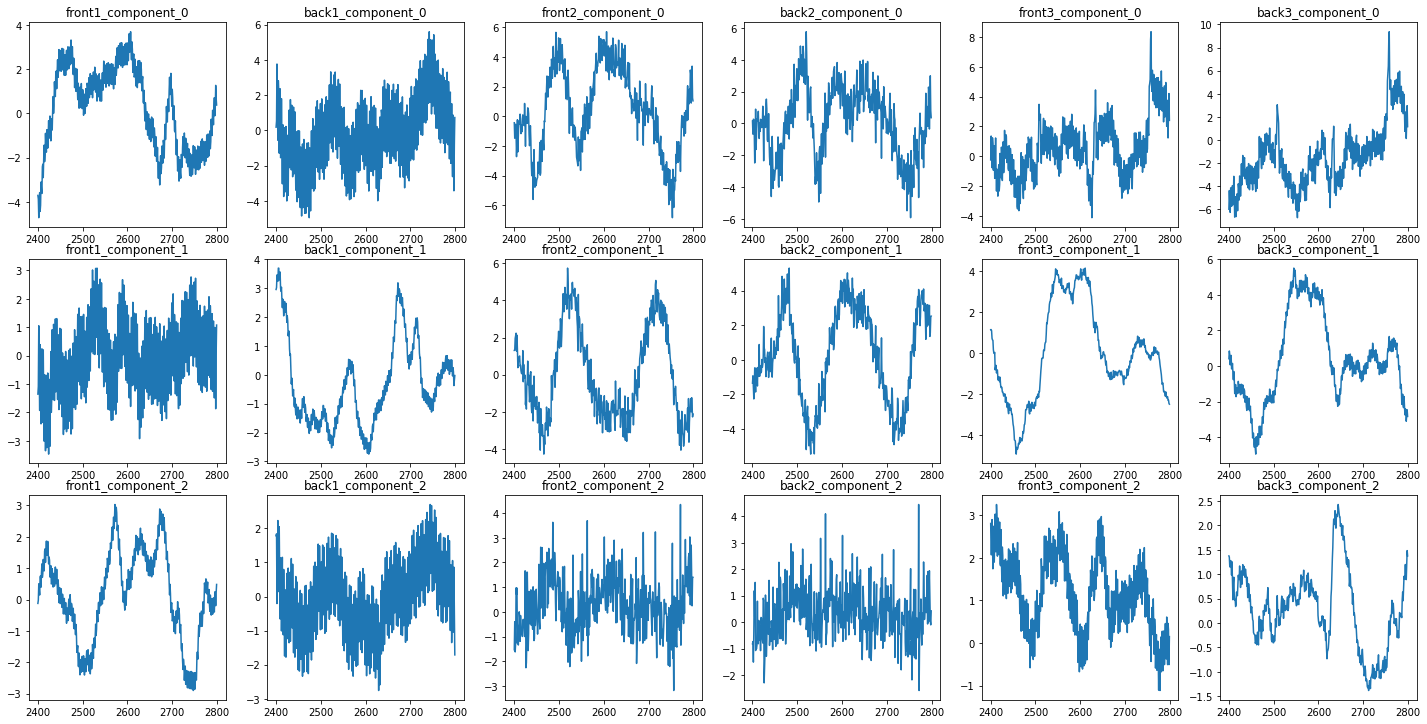

In [48]:
sub_eeg_list = [lrda_front1[2400:2800], lrda_back1[2400:2800],
                lrda_front2[2400:2800], lrda_back2[2400:2800],
                lrda_front3[2400:2800], lrda_back3[2400:2800]]
activity_signal_plots(sub_eeg_list, names, components, 10, 20)

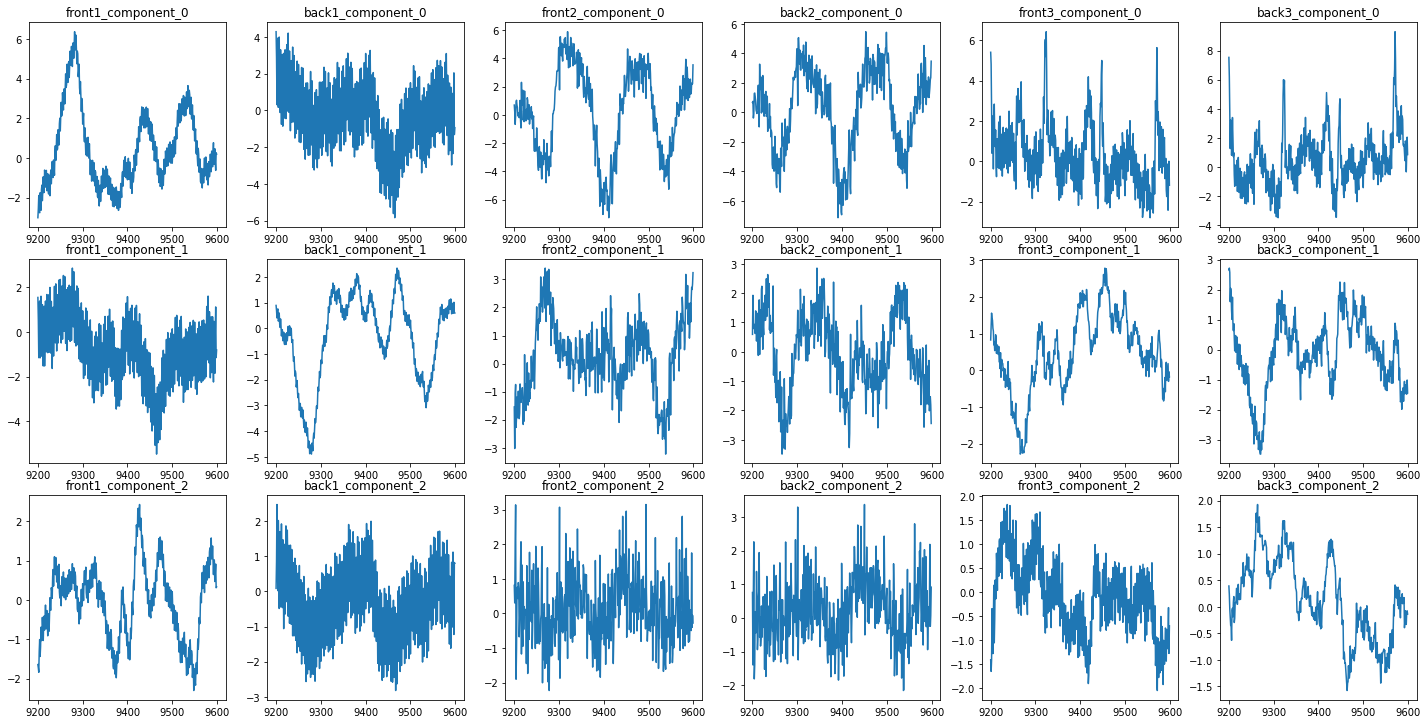

In [49]:
sub_eeg_list = [lrda_front1[9200:9600], lrda_back1[9200:9600],
                lrda_front2[9200:9600], lrda_back2[9200:9600],
                lrda_front3[9200:9600], lrda_back3[9200:9600]]
activity_signal_plots(sub_eeg_list, names, components, 10, 20)

##### GRDA Front/Back

In [50]:
grda_randoms = np.random.choice(grda_indexes, size = 3, replace = False)

In [51]:
grda_front1, grda_f1r = pca_function(scale(grda_df, grda_randoms[0]), front, 3)
grda_back1, grda_b1r = pca_function(scale(grda_df, grda_randoms[0]), back, 3)
grda_front2, grda_f2r = pca_function(scale(grda_df, grda_randoms[1]), front, 3)
grda_back2, grda_b2r = pca_function(scale(grda_df, grda_randoms[1]), back, 3)
grda_front3, grda_f3r = pca_function(scale(grda_df, grda_randoms[2]), front, 3)
grda_back3, grda_b3r = pca_function(scale(grda_df, grda_randoms[2]), back, 3)

names = ['front1', 'back1', 'front2', 'back2', 'front3', 'back3']
components = grda_front1.columns

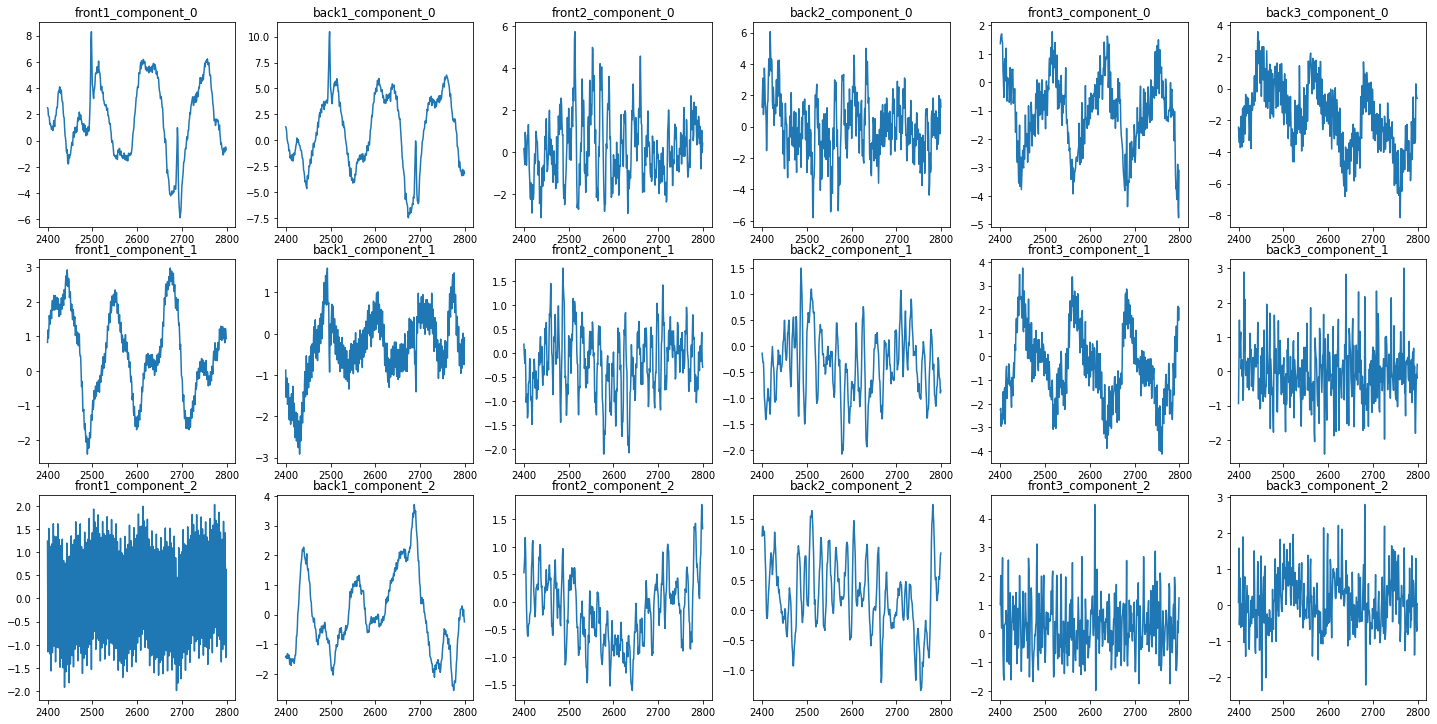

In [52]:
sub_eeg_list = [grda_front1[2400:2800], grda_back1[2400:2800],
                grda_front2[2400:2800], grda_back2[2400:2800],
                grda_front3[2400:2800], grda_back3[2400:2800]]
activity_signal_plots(sub_eeg_list, names, components, 10, 20)

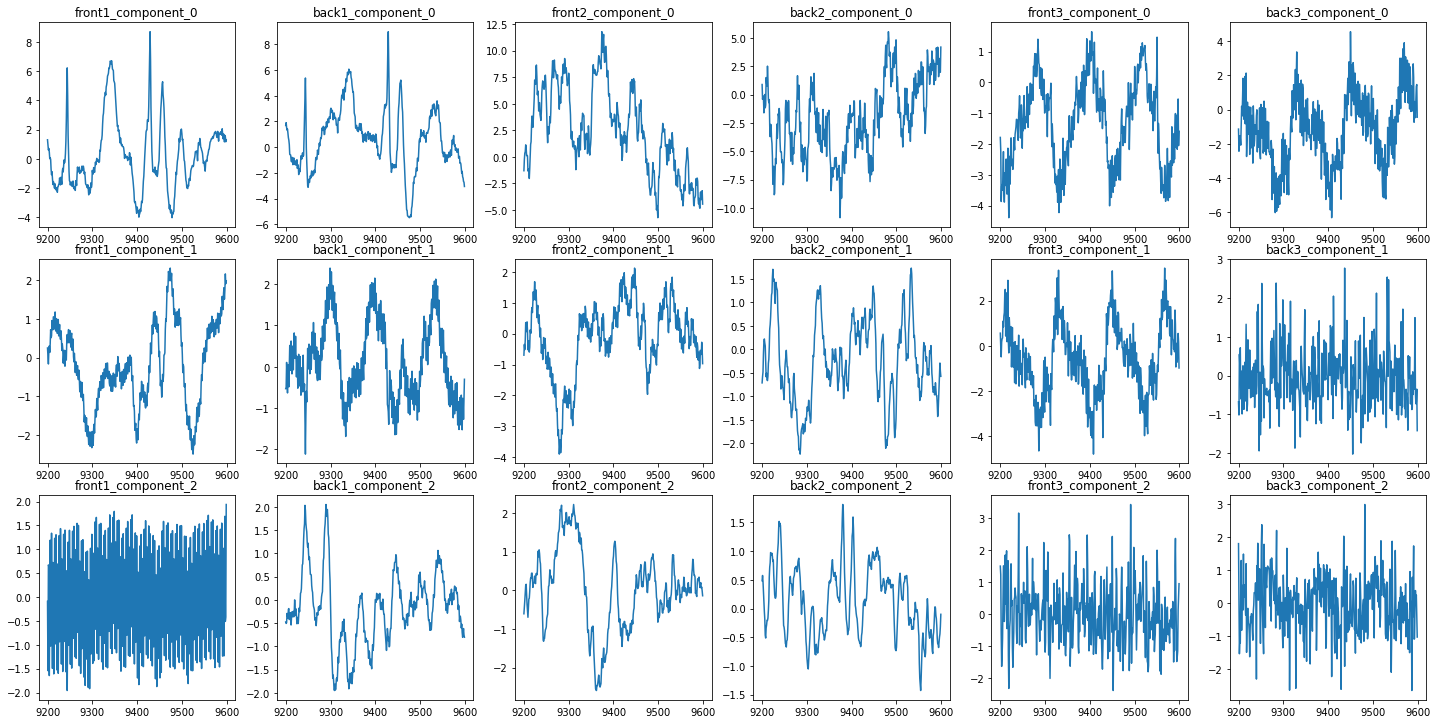

In [53]:
sub_eeg_list = [grda_front1[9200:9600], grda_back1[9200:9600],
                grda_front2[9200:9600], grda_back2[9200:9600],
                grda_front3[9200:9600], grda_back3[9200:9600]]
activity_signal_plots(sub_eeg_list, names, components, 10, 20)

In [54]:
grda_randoms[0]

7920

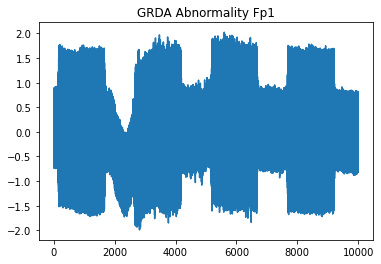

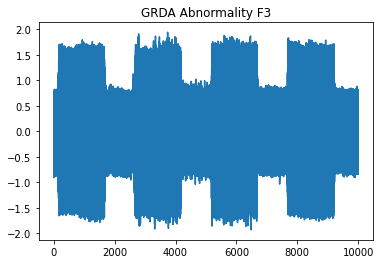

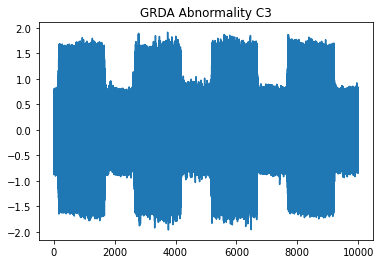

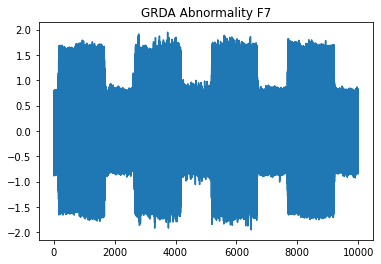

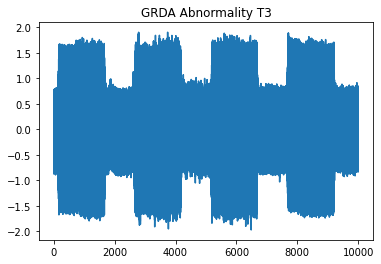

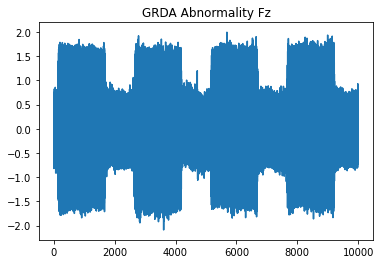

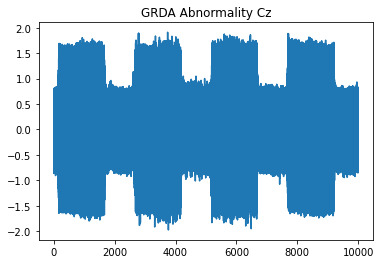

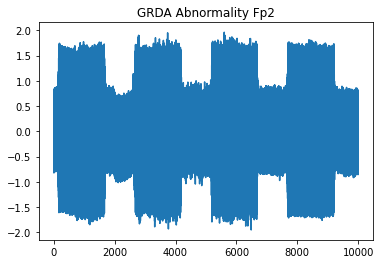

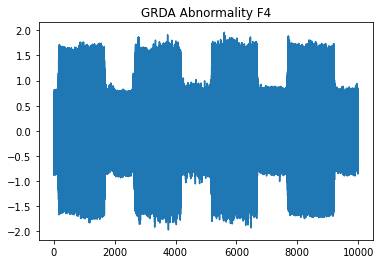

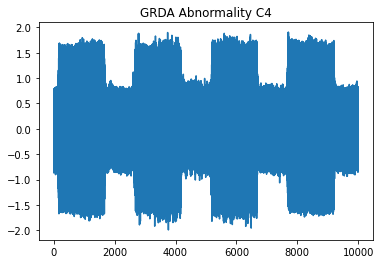

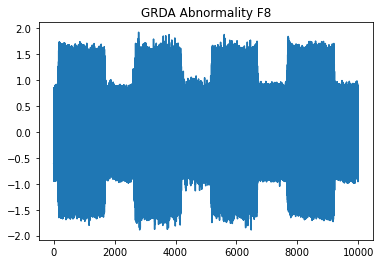

In [ ]:
grda_abnormal = scale(grda_df, 757)
for electrode in front:
    plt.plot(grda_abnormal[electrode])
    plt.title('GRDA Abnormality {}'.format(electrode))
    plt.show()

In [ ]:
grda_abnormal = scale(grda_df, 757)
for electrode in back:
    plt.plot(grda_abnormal[electrode])
    plt.title('GRDA Abnormality {}'.format(electrode))
    plt.show()

In [ ]:
for component in grda_front1.columns:
    plt.plot(grda_front1[component])
    plt.title('GRDA Abnormality Front PCA Full 50s {}'.format(component))
    plt.show()

In [ ]:
for component in grda_back1.columns:
    plt.plot(grda_back1[component])
    plt.title('GRDA Abnormality Back PCA Full 50s {}'.format(component))
    plt.show()

##### Other Front/Back

In [ ]:
other_randoms = np.random.choice(other_indexes, size = 3, replace = False)

In [ ]:
other_front1, other_f1r = pca_function(scale(other_df, other_randoms[0]), front, 3)
other_back1, other_b1r = pca_function(scale(other_df, other_randoms[0]), back, 3)
other_front2, other_f2r = pca_function(scale(other_df, other_randoms[1]), front, 3)
other_back2, other_b2r = pca_function(scale(other_df, other_randoms[1]), back, 3)
other_front3, other_f3r = pca_function(scale(other_df, other_randoms[2]), front, 3)
other_back3, other_b3r = pca_function(scale(other_df, other_randoms[2]), back, 3)

names = ['front1', 'back1', 'front2', 'back2', 'front3', 'back3']
components = other_front1.columns

In [ ]:
sub_eeg_list = [other_front1[2400:2800], other_back1[2400:2800],
                other_front2[2400:2800], other_back2[2400:2800],
                other_front3[2400:2800], other_back3[2400:2800]]
activity_signal_plots(sub_eeg_list, names, components, 10, 20)

In [ ]:
sub_eeg_list = [other_front1[9200:9600], other_back1[9200:9600],
                other_front2[9200:9600], other_back2[9200:9600],
                other_front3[9200:9600], other_back3[9200:9600]]
activity_signal_plots(sub_eeg_list, names, components, 10, 20)